### IMPORT MODULES

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure, show
from matplotlib.ticker import MaxNLocator
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from factor_analyzer import FactorAnalyzer
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans
from numpy import unique





pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)



### LOAD DATA

#### Load UEI Data

In [2]:
df_merged = pd.read_csv("input/survey_data_processed_scrambled.csv")

# Identify id_vars and X_columns
id_vars = ["My rank is: Response", "unit_type","Year", "location","wing","nma_category", "unit_type"]
X_columns = df_merged.drop(columns = ["Y"]+id_vars+ ["Rank"]).columns

#### Examine Survey data

In [3]:
df_merged[X_columns]

A grievance/complaint against my unit chain-of-command will be handled in a fair and timely manner by my chain-of-command  Airmen in my unit consider the environmental impact of their actions  During my performance feedback session, my supervisor provided me with feedback that enabled me to improve my performance prior to my annual performance review  I am allocated the correct amount of training hours each month to operate safely  I am encouraged to be innovative even if that means I might make a mistake  I am informed of critical information (e.g. work schedules, policies, uniform of the day, etc.) in a reasonable amount of time  I feel I am a valued member of my unit  I feel adequately prepared to deploy and execute my assigned AEF duties  I have been adequately trained for the job I am expected to do  I have easy and timely access to the written guidance I need to do my job (e.g., AFIs, MAJCOM Supplements, TOs, Self-Assessment Communicators, etc)  \
0                                                     1                                                                                                                          1                                                                     1                                                                                                                                                                1                                                                                 2                                                                           1                                                                                                                    2                                                  2                                                                        1                                                               0                                                                                                     
1                                                     0                                                                                                                          1                                                                     1                                                                                                                                                                1                                                                                 1                                                                           1                                                                                                                   -1                                                  1                                                                        1                                                               0                                                                                                     
2                                                     2                                                                                                                          2                                                                     0                                                                                                                                                                1                                                                                 1                                                                           2                                                                                                                    2                                                  1                                                                        2                                                               0                                                                                                     
3                                                     1                                                       

## Exploratory Factor Analysis
##### Documentation: https://www.datacamp.com/community/tutorials/introduction-factor-analysis

#### Confirm the p-value (0.0)

In [4]:
chi_square_value,p_value=calculate_bartlett_sphericity(df_merged[X_columns])
chi_square_value, p_value

(241029.5413333656, 0.0)

#### Obtain the Kaiser-Meyer-Olkin (KMO) Test value

In [5]:
kmo_all, kmo_model = calculate_kmo(df_merged[X_columns])

C:\AnacondaforJoe\anaconda3\lib\site-packages\factor_analyzer\utils.py:245: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  "The inverse of the variance-covariance matrix "


#### Confirm the KMO test value is above 0.6. (Factor analysis requires a value above 0.6. Higher is better.)


In [6]:
kmo_model

0.9782638711948335

#### Next, determine the correct number of factors using the Kaiser criterion and the scree plot

In [7]:
pca = PCA()
X_r = pca.fit_transform(df_merged[X_columns])
print('\nEigenvalues \n%s' %pd.DataFrame(pca.explained_variance_).head(20))


Eigenvalues 
            0
0   23.319493
1    4.025561
2    2.021408
3    1.846937
4    1.649486
5    1.490936
6    1.395636
7    1.316547
8    1.246737
9    1.168176
10   1.116187
11   1.019164
12   0.997844
13   0.936071
14   0.906380
15   0.825439
16   0.821253
17   0.793649
18   0.780106
19   0.755602


#### The Kaiser criterion suggests 11 factors (visualized by scree plot below)

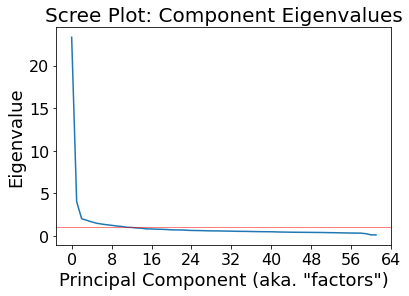

In [8]:
def scree_plot():


    ax = figure().gca()
    ax.plot(pca.explained_variance_)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel('Principal Component (aka. "factors")', fontsize = 18)
    plt.ylabel('Eigenvalue', fontsize = 18)
    plt.axhline(y=1, linewidth=1, color='r', alpha=0.5)
    plt.title('Scree Plot: Component Eigenvalues', fontsize = 20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    show()

scree_plot()

#### Update: Testing showed consistents were most consistent at 9 factors, manually tuned down from 11. 

In [9]:
number_of_factors = 9 # Equal to # of components with Eigenvalue above 1.0. Update: Tuned from 11 down to 9. 

#### Display the loadings values and proportional variance per factor for each of the 9 factors. 

In [10]:
fa = FactorAnalyzer(n_factors = number_of_factors, rotation = 'varimax') # try rotation = None
fa.fit(df_merged[X_columns])
loadings = fa.loadings_
factor_temp_df = pd.DataFrame(fa.get_factor_variance(), index = ["Sum of squared loadings (variance)",
                                                      "Proportional variance","Cumulative variance"])

round(factor_temp_df,2)

0     1     2     3     4     5     6     7     8
Sum of squared loadings (variance)  9.92  3.76  2.92  2.49  2.38  2.18  2.12  1.95  1.58
Proportional variance               0.16  0.06  0.05  0.04  0.04  0.04  0.03  0.03  0.03
Cumulative variance                 0.16  0.22  0.27  0.31  0.35  0.38  0.42  0.45  0.47

#### Display the cumulative variance plot below (The 9 factors explain about 47% of the variance in the survey questions)

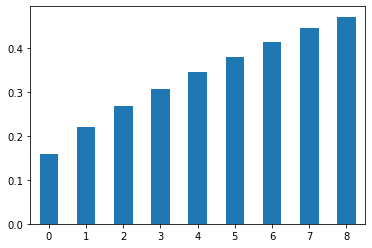

In [11]:
ax =factor_temp_df.loc["Cumulative variance",:].plot.bar(rot=0)

#### Transform loadings array to dataframes and designate each index with the correct question and each column as the correct factor

In [12]:
loadings_df = pd.DataFrame(loadings)
loadings_df = loadings_df.set_index(X_columns)

# Rename each factor accoring to their previously  identified group similarities. 
factor_name_dict = {0:"Leadership", 1:"Strategic Plan", 2:"Impact of Additional Duties",
                    3:"Equipment", 4:"Duty Schedule", 5:"Supervisor", 6:"Adequate Training",
                    7:"Sufficient Personnel", 8:"Sexual Harrassment / Suicide"}
loadings_df.rename(factor_name_dict, axis='columns', inplace=True)



#### Use the "max_abs_load" criteria to filter to only factors that have questions that meet a 0.5 threshold with any factor. 

In [13]:
loadings_df_2 = loadings_df.copy()
loadings_df_2["max_abs_load"] = loadings_df.T.abs().max()
loadings_df_filtered_rows = loadings_df_2[loadings_df_2["max_abs_load"]>0.5]
loadings_df_filtered_rows

Leadership  Strategic Plan  Impact of Additional Duties  Equipment  Duty Schedule  Supervisor  Adequate Training  Sufficient Personnel  Sexual Harrassment / Suicide  max_abs_load
A grievance/complaint against my unit chain-of-...    0.625469        0.356631                     0.119885   0.104159       0.110926    0.098622           0.080584              0.109911                      0.162220      0.625469
During my performance feedback session, my supe...    0.279746        0.122898                     0.071377   0.065552       0.082693    0.508552           0.149903              0.031514                      0.062785      0.508552
I am encouraged to be innovative even if that m...    0.543914        0.163897                     0.096541   0.161891       0.288888    0.150530           0.105919              0.080381                      0.002497      0.543914
I feel I am a valued member of my unit                0.653185        0.164366                     0.050687   0.093109       0.223593    0.199894           0.248758              0.042586                      0.101165      0.653185
I have been adequately trained for the job I am...    0.178746        0.140711                     0.210178   0.167490       0.043141    0.197867           0.561759              0.126607                      0.072223      0.561759
I have easy and timely access to the written gu...    0.132233        0.033998                     0.129116   0.504517       0.105787    0.083664           0.118927              0.015705                      0.070150      0.504517
I trust my leadership chain, from my supervisor...    0.673083        0.167817                     0.154372   0.141165       0.164193    0.184534           0.108181              0.122745                      0.077286      0.673083
Individuals in my unit are comfortable approach...    0.576409        0.135448                     0.090510   0.175770       0.072764    0.274313           0.080371              0.092420                      0.126281      0.576409
Members of my unit take good care of the equipm...    0.273844        0.063096                    -0.020750   0.611557       0.085896    0.045936           0.017929              0.041771                      0.077755      0.611557
My commander is concerned about my personal wel...    0.570510        0.155694                     0.080298   0.115731       0.166259    0.132903           0.110381              0.037977                      0.194191      0.570510
My duty schedule is predictable enough for me t...    0.158966        0.089463                     0.216165   0.130420       0.574576    0.103504           0.038521              0.154975                      0.058675      0.574576
My leadership gets the right information about ...    0.557976        0.442352                     0.158898   0.163407       0.105679    0.083205           0.059750              0.125339                      0.080424      0.557976
My supervisor is concerned with my professional...    0.421441        0.113267                     0.081658   0.050022       0.102582    0.590025           0.128133              0.033212                      0.093060      0.590025
My unit has a sufficient number of experienced ...    0.183790        0.106872                     0.250774   0.079892       0.123012    0.089721           0.127351              0.632012                     -0.005208      0.632012
My unit has a sufficient number of personnel to...    0.111485        0.070311                     0.235609   0.006307       0.174656    0.040119           0.081238              0.690024                      0.006254      0.690024
My unit is serious about preventing sexual assa...    0.311743        0.138982                     0.044346   0.131427       0.060108    0.150158           0.092833              0.008288                      0.767744      0.767744
My unit leadership chain applies disciplinary s...    0.707684        0.179920                     0.076708   0.165522       

#### Eliminate any factors that don't have at least 1 question that meets the 0.5 threshold (usually eliminates none)

In [14]:
keep_loadings_columns = loadings_df_filtered_rows.max()[loadings_df_filtered_rows.max()>0.5].index

#### Build a dictionary that identifies the essential questions for each factor

In [15]:
factor_essential_loadings_dict = {}
loadings_df_filtered_rows_columns = loadings_df_filtered_rows[keep_loadings_columns]
for col in loadings_df_filtered_rows_columns.columns:
    if col != "max_abs_load":
        factor_essential_loadings_dict[col] = loadings_df_filtered_rows_columns[loadings_df_filtered_rows_columns[col]>0.5][col]
        print("column: ", str(col)+":")
        print(loadings_df_filtered_rows_columns[loadings_df_filtered_rows_columns[col]>0.5].sort_values(by=col, ascending = False)[col])
        print("")


column:  Leadership:
My unit leadership chain applies disciplinary standards in a fair and consistent manner                                      0.707684
My unit leadership chain consistently reinforces the USAF Core Values and their application to daily operations              0.700365
I trust my leadership chain, from my supervisor to my Wing Commander (or FOA/DRU Commander)                                  0.673083
My units leaders reward individual performance fairly                                                                        0.659162
I feel I am a valued member of my unit                                                                                       0.653185
A grievance/complaint against my unit chain-of-command will be handled in a fair and timely manner by my chain-of-command    0.625469
Teamwork at all levels is prevalent throughout my unit                                                                       0.617372
Standards in my unit are enforced        

#### Use the above results to alter "factor_name_dict" to give a name for each factor that best describes their question set. Foe example: "Leadership"


### This is the end of the Exploratory Factor Analysis portion of the notebook

## Clustering Analysis
##### Cluster Analysis Documentation: https://machinelearningmastery.com/clustering-algorithms-with-python/

In [16]:
df_merged2 = df_merged.copy()
df_merged.to_csv("clustering_data/pre_clustering_scrambled.csv")

#### Use the loadings of the identified questions that meet the threshold to build a weighted column for each factor. 

In [17]:
for factor in factor_essential_loadings_dict.keys():
    df_merged2[factor] = (df_merged2[factor_essential_loadings_dict[factor].index]*factor_essential_loadings_dict[factor]).sum(axis=1)
# Rather than use all questions for each factor, only questions that meet the 0.5 threshold will be used. 

In [18]:
df_merged2

unit_type My rank is: Response  Rank  Year  A grievance/complaint against my unit chain-of-command will be handled in a fair and timely manner by my chain-of-command  Airmen in my unit consider the environmental impact of their actions  During my performance feedback session, my supervisor provided me with feedback that enabled me to improve my performance prior to my annual performance review  I am allocated the correct amount of training hours each month to operate safely  I am encouraged to be innovative even if that means I might make a mistake  I am informed of critical information (e.g. work schedules, policies, uniform of the day, etc.) in a reasonable amount of time  I feel I am a valued member of my unit  I feel adequately prepared to deploy and execute my assigned AEF duties  I have been adequately trained for the job I am expected to do  \
0        Operator                O4-O6     5  2014                                                  1                                                                                                                          1                                                                     1                                                                                                                                                                1                                                                                 2                                                                           1                                                                                                                    2                                                  2                                                                        1                
1     Maintenance                E4-E6     2  2014                                                  0                                                                                                                          1                                                                     1                                                                                                                                                                1                                                                                 1                                                                           1                                                                                                                   -1                                                  1                                                                        1                
2        Operator                E4-E6     2  2014                                                  2                                                                                                                          2                                                                     0                                                                                                                                                                1                                                                                 1                                                                           2                                                                                                                    2                                                  1                                                                        2                
3        Operator                E4-E6     2  2014                                                  1                                                                                                                          1                                                                     1                                                                                                                                                                1                                                                     

In [19]:
num_clusters = 5
writer2 = pd.ExcelWriter(r"clustering_data/"+str(num_clusters)+"_clusters_factors_scrambled.xlsx")

for j in range(10):

    cluster_X_columns = ['My unit leadership chain applies disciplinary standards in a fair and consistent manner',
                         'My units strategic plan translates to what I do on a daily basis',
                         'Performing my primary AFSC duties is NOT significantly impacted by additional duties',
                         'Members of my unit take good care of the equipment they use',
                         'My duty schedule is predictable enough for me to plan and participate in off-duty activities',
                         'My supervisor is concerned with my professional development',
                         'I have been adequately trained for the job I am expected to do',
                         'My unit has a sufficient number of personnel to accomplish our primary mission',
                         'My unit is serious about preventing sexual assault and sexual harassment'] # unused atm
    cluster_X_columns = list(factor_essential_loadings_dict.keys())

    # define the model
    #model = DBSCAN(eps=0.20, min_samples=3)
    model = GaussianMixture(n_components=num_clusters, random_state=1)
    #model = KMeans(init="random", n_clusters=9, n_init=10,  max_iter=300,  random_state=42)

    # Scaled Featuers
    scaler = StandardScaler()
    Scaled_Features = scaler.fit_transform(df_merged2[cluster_X_columns ])


    # fit the model
    yhat = model.fit_predict(Scaled_Features)

    # assign a cluster to each example
    df_merged_cluster = pd.DataFrame(Scaled_Features, columns = cluster_X_columns).copy()
    ###yhat = model.predict(Scaled_Features)


    df_merged_cluster['clusters'] = yhat
    df_merged2['clusters'] = yhat 

    # Add back and process observational variables
    numerical_observational_columns = ['Y'] # ["Rank"] 
    Scaled_Features = scaler.fit_transform(df_merged2[numerical_observational_columns ])
    df_observational = pd.DataFrame(Scaled_Features, columns = numerical_observational_columns).copy()
    df_merged_cluster[numerical_observational_columns] = df_observational[numerical_observational_columns].values #= ["My rank is: Response","unit_orig", "unit_type", "Year"]

    # Create aggregate cluster dataframe
    aggregate_df = pd.DataFrame(columns = cluster_X_columns + numerical_observational_columns + ["size"]   )
    for rank in sorted(set(df_merged["My rank is: Response"].unique())):
            aggregate_df[rank] = ""
            #aggregate_df[rank+"_perc"] = 0.0
    for un_t in sorted(set(df_merged["unit_type"].unique())):
            aggregate_df[un_t] = ""
    for loc in sorted(set(df_merged2["location"].value_counts().head().index)):
            aggregate_df[loc] = ""
    for wing in sorted(set(df_merged2["wing"].value_counts().head().index)):
            aggregate_df[wing] = ""
            #aggregate_df[un_t+"_perc"] = 0.0
    for cat in sorted(set(df_merged2["nma_category"].value_counts().head().index)):
            aggregate_df[cat] = ""
            #df_merged2.nma_category.value_counts().head().index
            
    for cluster in range(num_clusters):
        
        # Implement cluster_size columns
        sub_cluster_df = df_merged_cluster.loc[df_merged_cluster.clusters == cluster, cluster_X_columns+numerical_observational_columns ]
        sub_cluster_len = len(sub_cluster_df)
        print("cluster:", cluster, "cluster_size: ", sub_cluster_len)
        # Initialize subcluster row
        sub_cluster_agg_df = pd.DataFrame(round(sub_cluster_df.mean(),2)).T
        sub_cluster_agg_df["size"] = sub_cluster_len
        
        # Implement rank columns
        for rank in sorted(set(df_merged["My rank is: Response"].unique())):
            sub_cluster_agg_df[rank] = len(df_merged2.loc[(df_merged2["My rank is: Response"] == rank)&(df_merged2.clusters == cluster), : ])
            sub_cluster_agg_df[rank+"_perc"] = round(len(df_merged2.loc[(df_merged2["My rank is: Response"] == rank)&(df_merged2.clusters == cluster), : ])/len(df_merged2.loc[(df_merged2.clusters == cluster), : ]),2)
        for un_t in sorted(set(df_merged["unit_type"].unique())):
            sub_cluster_agg_df[un_t] = len(df_merged2.loc[(df_merged2["unit_type"] == un_t)&(df_merged2.clusters == cluster), : ])
            sub_cluster_agg_df[un_t+"_perc"] = round(len(df_merged2.loc[(df_merged2["unit_type"] == un_t)&(df_merged2.clusters == cluster), : ])/len(df_merged2.loc[(df_merged2.clusters == cluster), : ]),2)
        for loc in sorted(set(df_merged2["location"].value_counts().head().index)):
            sub_cluster_agg_df[loc] = len(df_merged2.loc[(df_merged2["location"] == loc)&(df_merged2.clusters == cluster), : ])
            sub_cluster_agg_df[loc+"_perc"] = round(len(df_merged2.loc[(df_merged2["location"] == loc)&(df_merged2.clusters == cluster), : ])/len(df_merged2.loc[(df_merged2.clusters == cluster), : ]),2)
        for wing in sorted(set(df_merged2["wing"].value_counts().head().index)):
            sub_cluster_agg_df[wing] = len(df_merged2.loc[(df_merged2["wing"] == wing)&(df_merged2.clusters == cluster), : ])
            sub_cluster_agg_df[wing+"_perc"] = round(len(df_merged2.loc[(df_merged2["wing"] == wing)&(df_merged2.clusters == cluster), : ])/len(df_merged2.loc[(df_merged2.clusters == cluster), : ]),2)
        for cat in sorted(set(df_merged2["nma_category"].value_counts().head().index)):
            sub_cluster_agg_df[cat] = len(df_merged2.loc[(df_merged2["nma_category"] == cat)&(df_merged2.clusters == cluster), : ])
            sub_cluster_agg_df[cat+"_perc"] = round(len(df_merged2.loc[(df_merged2["nma_category"] == cat)&(df_merged2.clusters == cluster), : ])/len(df_merged2.loc[(df_merged2.clusters == cluster), : ]),2)
        
        sub_cluster_agg_df.index = [cluster]
        
        # Concatenate cluster row
        aggregate_df = pd.concat([aggregate_df, sub_cluster_agg_df])

    aggregate_df_analyzed = aggregate_df.copy()
    aggregate_df_analyzed["factor_description"] = ""

    for index, row in aggregate_df_analyzed.iterrows():
        #print("index", index)
        try:
            for factor in cluster_X_columns:
                smallest_var = aggregate_df_analyzed[factor].sort_values().unique()[0]
                second_smallest_var = aggregate_df_analyzed[factor].sort_values().unique()[1]
                largest_var = aggregate_df_analyzed[factor].sort_values().unique()[-1]
                second_largest_var = aggregate_df_analyzed[factor].sort_values().unique()[-2]

                if aggregate_df_analyzed.loc[index, factor] == smallest_var:
                    aggregate_df_analyzed.loc[index, "factor_description"] =  aggregate_df_analyzed.loc[index, "factor_description"] + "Worst \"" + factor + "\"" + ".   "   
               
                elif aggregate_df_analyzed.loc[index, factor] == largest_var:
                    aggregate_df_analyzed.loc[index, "factor_description"] =  aggregate_df_analyzed.loc[index, "factor_description"] + "Best \"" + factor + "\"" +  ".   "

                else:
                    pass
        except:
            print("error. skip.")
            pass
    aggregate_df_analyzed.to_excel(writer2, sheet_name = 'f_'+str(j), index = False)
 
    
writer2.save()
writer2.close()
aggregate_df.sort_values(by=['Y'], ascending=False)
#df_merged_cluster.loc[:, id_vars] = df_merged2[id_vars]

cluster: 0 cluster_size:  2629
cluster: 1 cluster_size:  747
cluster: 2 cluster_size:  824
cluster: 3 cluster_size:  2225
cluster: 4 cluster_size:  1442
cluster: 0 cluster_size:  2629
cluster: 1 cluster_size:  747
cluster: 2 cluster_size:  824
cluster: 3 cluster_size:  2225
cluster: 4 cluster_size:  1442
cluster: 0 cluster_size:  2629
cluster: 1 cluster_size:  747
cluster: 2 cluster_size:  824
cluster: 3 cluster_size:  2225
cluster: 4 cluster_size:  1442
cluster: 0 cluster_size:  2629
cluster: 1 cluster_size:  747
cluster: 2 cluster_size:  824
cluster: 3 cluster_size:  2225
cluster: 4 cluster_size:  1442
cluster: 0 cluster_size:  2629
cluster: 1 cluster_size:  747
cluster: 2 cluster_size:  824
cluster: 3 cluster_size:  2225
cluster: 4 cluster_size:  1442
cluster: 0 cluster_size:  2629
cluster: 1 cluster_size:  747
cluster: 2 cluster_size:  824
cluster: 3 cluster_size:  2225
cluster: 4 cluster_size:  1442
cluster: 0 cluster_size:  2629
cluster: 1 cluster_size:  747
cluster: 2 cluster_si

C:\AnacondaforJoe\anaconda3\lib\site-packages\xlsxwriter\workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


Leadership  Strategic Plan  Impact of Additional Duties  Equipment  Duty Schedule  Supervisor  Adequate Training  Sufficient Personnel  Sexual Harrassment / Suicide     Y  size E1-E3 E4-E6 E7-E9 General Officer O1-O3 O4-O6 Maintenance  NC3 Operator Safety Security  AAI MAND MCAK OANE WAFM 201SD 202ARD 301FD 5009BD 50BD Bomber  DCA Missile Space Tanker  E1-E3_perc  E4-E6_perc  E7-E9_perc  General Officer_perc  O1-O3_perc  O4-O6_perc  Maintenance_perc  NC3_perc  Operator_perc  Safety_perc  Security_perc  AAI_perc  MAND_perc  MCAK_perc  OANE_perc  WAFM_perc  201SD_perc  202ARD_perc  301FD_perc  5009BD_perc  50BD_perc  Bomber_perc  DCA_perc  Missile_perc  Space_perc  Tanker_perc
3        0.86            0.63                         0.31       0.47           0.72        0.74               0.65                  0.41                          0.75  0.66  2225   253   927   478               2   273   292         638  228      847     26      486  177  264  237  117  220   163    195   177    220  149    361  313     154   281    600        0.11        0.42        0.21                   0.0        0.12        0.13              0.29      0.10           0.38         0.01           0.22      0.08       0.12       0.11       0.05       0.10        0.07         0.09        0.08         0.10       0.07         0.16      0.14          0.07        0.13         0.27
0       -0.15           -0.09                         0.13      -0.16           0.31       -0.15               0.03                  0.12                         -0.41 -0.02  2629   431  1353   444               0   236   165         855  251      827     22      674  200  335  290  123  347   169    266   200    347  189    512  373     180   271    677        0.16        0.51        0.17                   0.0        0.09        0.06              0.33      0.10           0.31         0.01           0.26      0.08       0.13       0.11       0.05       0.13        0.06         0.10        0.08         0.13       0.07         0.19      0.14          0.07        0.10         0.26
2       -0.07           -0.19                        -0.22      -0.08          -0.69       -0.04              -0.42                 -0.20                         -0.60 -0.15   824   140   403   103               1   121    56         232   73      315      7      197   54  108   86   29   97    39     84    54     97   53    146  114      64    75    237        0.17        0.49        0.12                   0.0        0.15        0.07              0.28      0.09           0.38         0.01           0.24      0.07       0.13       0.10       0.04       0.12        0.05         0.10        0.07         0.12       0.06         0.18      0.14          0.08        0.09         0.29
4       -0.17           -0.13                        -0.33       0.01          -0.76       -0.22              -0.35                 -0.44                          0.75 -0.28  1442   122   720   210               0   268   122         424  145      554     16      303   96  186  170   67  174    81    168    96    174   85    256  182     120   153    416        0.08        0.50        0.15                   0.0        0.19        0.08              0.29      0.10           0.38         0.01           0.21      0.07       0.13       0.12       0.05       0.12        0.06         0.12        0.07         0.12       0.06         0.18      0.13          0.08        0.11         0.29
1       -1.64           -1.08                        -0.51      -0.78          -1.02       -1.21              -0.89                 -0.58                         -1.56 -1.20   747   102   499    69               0    49    28         223   59      190      7      268   51  120   88   42   95    44     84    51     95   49    143  107      81    69    204        0.14        0.67        0.09                   0.0        0.07        0.04              0.30      0.08           0.25         0.01           0.36      0.07       0.16       0.12       0.06       0.13     

In [20]:
df_merged2.nma_category.value_counts().head().index

Index(['Tanker', 'Bomber', 'DCA', 'Space', 'Missile'], dtype='object')

In [21]:
df_merged2.to_csv("clustering_data/post_clustering_csv_scrambled.csv")